In [1]:
import pathlib
import dask.dataframe as dd
import psutil
import numpy as np
import pandas as pd

In [2]:
# print amount of available RAM memory
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 8.25 GB


In [3]:
n_samples = 100_000_000
distance_mean_m = 100
distance_sigma_m = 10
time_mean_s = 10
time_sigma_s = 0.1

In [4]:
df = pd.DataFrame(
    {
        "distance_m" : np.random.normal(loc=distance_mean_m, scale=distance_sigma_m, size=n_samples),
        "time_s": np.random.normal(loc=time_mean_s, scale=time_sigma_s, size=n_samples)
    }
)

In [7]:
df.to_hdf("speed.h5", key="df", mode="w", complevel=5, complib="blosc:zstd", format="table")

In [3]:
df2 = pd.read_hdf("speed.h5", key="df")

In [6]:
df2.head()

,distance_m,time_s
0,104.032798,10.098426
1,93.054881,10.148043
2,90.496592,10.007495
3,85.085938,9.984599
4,95.340534,9.885953


In [9]:
hist, xedges, yedges = np.histogram2d(df2.distance_m, df2.time_s, bins=500)

In [7]:
bins, edges = np.histogram(df2.distance_m, bins=1000)

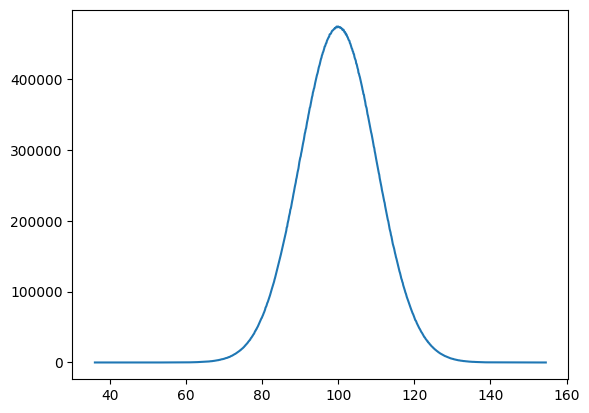

In [8]:
import matplotlib.pyplot as plt
plt.plot(edges[:-1], bins)

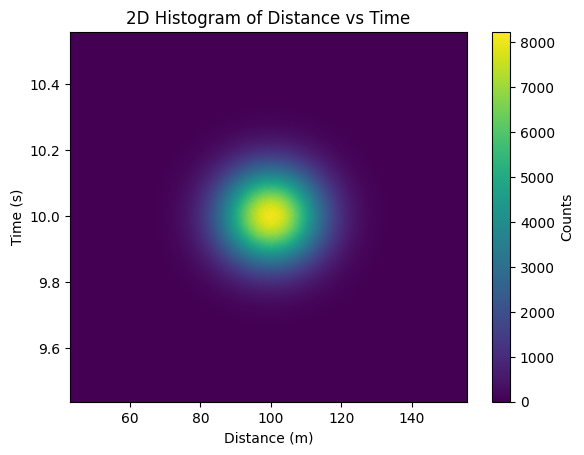

In [10]:
# plot the histogram
import matplotlib.pyplot as plt
plt.imshow(hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('2D Histogram of Distance vs Time')
plt.colorbar(label='Counts')
plt.show()

In [1]:
from dask.distributed import Client
client = Client()
client

ImportError: cannot import name 'HLGExpr' from 'dask._expr' (/home/grzanka/workspace/hpda-2025/venv/lib/python3.12/site-packages/dask/_expr.py)

In [3]:
df = dd.read_hdf("speed.h5", key="df")

In [4]:
df.head()

,distance_m,time_s
0,104.032798,10.098426
1,93.054881,10.148043
2,90.496592,10.007495
3,85.085938,9.984599
4,95.340534,9.885953


In [3]:
import dask.dataframe as dd
import dask_histogram as dh

df = dd.read_hdf("speed.h5", key="df")

# Compute min and max for range
x_min, x_max = df['distance_m'].min().compute(), df['distance_m'].max().compute()
y_min, y_max = df['time_s'].min().compute(), df['time_s'].max().compute()

bins = (500, 500)
range_ = [(x_min, x_max), (y_min, y_max)]  

# Provide range argument together with bins
hist, xedges, yedges = dh.histogram2d(df['distance_m'], df['time_s'], bins=bins, range=range_)

hist_np = hist.compute()
xedges_np = xedges.compute()
yedges_np = yedges.compute()


KeyError: 'getitem-06ddef30d2bafb8397c9d8fe3521fe76'